In [4]:
from keras.models import Sequential
from keras.layers import Dense, SpatialDropout1D, Embedding, LSTM, Conv1D, GlobalMaxPooling1D
from keras.layers import Dropout
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
import pandas as pd
import keras
import tensorflow as tf
import numpy as np
import cv2

In [8]:
MAX_FEATURES = 30000
NUM_FILTERS = 256 
NUM_WORDS = 4
EMBED_DIM = 512

dataset = pd.read_csv('processed_train_data.csv')

tokenizer = Tokenizer(num_words=MAX_FEATURES, split=' ')
tokenizer.fit_on_texts(dataset['text'].values)
X = tokenizer.texts_to_sequences(dataset['text'].values)

X = pad_sequences(X, maxlen=374)
Y = tf.keras.utils.to_categorical(dataset['target'].values.tolist(), 3)

X_Test = pd.read_csv('processed_test_data.csv')['text'].values.tolist()
X_Test = tokenizer.texts_to_sequences(X_Test)

In [5]:
def cnn():
    model = Sequential()
    model.add(Embedding(MAX_FEATURES, EMBED_DIM, input_length=374))
    model.add(SpatialDropout1D(0.5))
    model.add(Conv1D(filters=64, kernel_size=NUM_WORDS, activation="relu"))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(3, activation="softmax"))
    model.compile(optimizer="adam", loss="categorical_crossentropy",metrics=["acc"])
    return model

model = cnn()

In [ ]:
history = model.fit(X, Y, batch_size=1024,
                    epochs=1, validation_split=0.2)
model.save('CNN_512b_2e')

In [ ]:
predictions = model.predict(X_Test)
preds = np.argmax(predictions, 1)
csv = 'id,target\n'
for id, pred in enumerate(preds):
  csv += '{},{}\n'.format(id, pred)
with open('submission.csv', 'w') as f:
  f.writelines(csv)

# Explainability of the model

## How is the decision explained?
Gradient-based methods are used to explain the decision of the model. The model is trained to predict the class of the image. The gradient of the loss function with respect to the input image is calculated. The gradient is then used to explain the decision of the model. The gradient is a vector of the same size as the input image. The gradient is used to calculate the saliency map. The saliency map is a heatmap of the same size as the input. The saliency map is used to explain the decision of the model.

In [29]:
def get_grad_cam(model, text):
    text = tokenizer.texts_to_sequences([text])
    text = pad_sequences(text, maxlen=374)
    text = tf.convert_to_tensor(text)
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv1d_1')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(text)
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
        heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
        heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
        return heatmap

def plot_grad_cam(heatmap, text):
    heatmap = np.uint8(255 * heatmap)
    superimposed_img = (heatmap * 0.4)
    plt.imshow(superimposed_img.reshape(7, 53))
    print(text)

model = keras.models.load_model('CNN_2')

i had a great time at the party last night. i disliked the food, but the music was great. also, the people were very friendly.


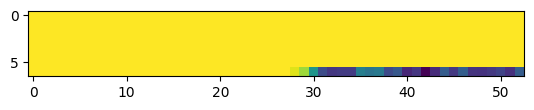

In [66]:
text = 'i had a great time at the party last night. i disliked the food, but the music was great. also, the people were very friendly.'
heatmap = get_grad_cam(model, text)
plot_grad_cam(heatmap, text)

horrible, terrible, bad


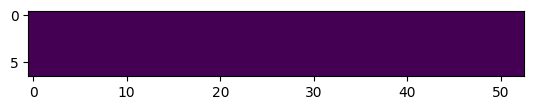

In [63]:
neg_text = 'horrible, terrible, bad'
heatmap = get_grad_cam(model, neg_text)
plot_grad_cam(heatmap, neg_text)

amazing, okay, fabulous, fantastic


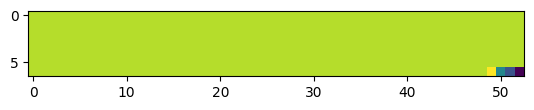

In [65]:
heatmap = get_grad_cam(model, 'amazing, okay, fabulous, fantastic')
plot_grad_cam(heatmap, 'amazing, okay, fabulous, fantastic')